In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#to process the data
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

#to import iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# fro machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

#for classfication
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier  
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#for metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,mean_absolute_error,r2_score,mean_squared_error,f1_score,precision_score,recall_score

#import pipeline
from sklearn.pipeline import Pipeline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



#data 

In [2]:
#load dataset
df = pd.read_csv('./heart_disease_uci.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


# EDA

In [3]:
# data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [20]:
#data shape
print('There are {} rows and {} columns in the dataset'.format(df.shape[0],df.shape[1]))

There are 920 rows and 16 columns in the dataset


## Null Data 

In [4]:
df.isnull().sum().sort_values(ascending=False)


ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalch       55
exang        55
chol         30
restecg       2
id            0
age           0
sex           0
dataset       0
cp            0
num           0
dtype: int64

In [5]:
missing_data_cols=df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False).index.to_list()
missing_data_cols

['ca',
 'thal',
 'slope',
 'fbs',
 'oldpeak',
 'trestbps',
 'thalch',
 'exang',
 'chol',
 'restecg']

In [6]:
# sorting columns by datatypes
# cat_cols=df.select_dtypes('object').columns
# num_cols=df.select_dtypes('float64','int64').columns
# bool_cols=df.select_dtypes('bool').columns

In [14]:
cat_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
num_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [15]:
# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [16]:

# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in cat_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in num_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values ca : 66.41%
The feature 'ca' has been imputed with 70.97 accuracy

Missing Values thal : 52.83%
The feature 'thal' has been imputed with 70.11 accuracy

Missing Values slope : 33.59%
The feature 'slope' has been imputed with 67.48 accuracy

Missing Values fbs : 9.78%
The feature 'fbs' has been imputed with 80.72 accuracy

Missing Values oldpeak : 6.74%
MAE = 0.6183139534883721 

RMSE = 0.8306383297703767 

R2 = 0.3426723797985809 

Missing Values trestbps : 6.41%
MAE = 13.18294797687861 

RMSE = 17.228268123736424 

R2 = 0.07325331474899777 

Missing Values thalch : 5.98%
MAE = 16.78705202312139 

RMSE = 21.576550694779577 

R2 = 0.32305505494267384 

Missing Values exang : 5.98%
The feature 'exang' has been imputed with 76.88 accuracy

Missing Values chol : 3.26%
MAE = 44.56640449438202 

RMSE = 63.26910269776058 

R2 = 0.6828957987783013 

Missing Values restecg : 0.22%
The feature 'restecg' has been imputed with 65.22 accuracy



In [17]:
#checking the null data in the dataset
print("Null Data in the Dataset: ", df.isnull().sum())
print("Number of Null Values: ", df.isnull().sum().sum())
print("Percentage of Null Values: ", round((df.isnull().sum().sum()/len(df))*100,2),"%")    


Null Data in the Dataset:  id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64
Number of Null Values:  0
Percentage of Null Values:  0.0 %


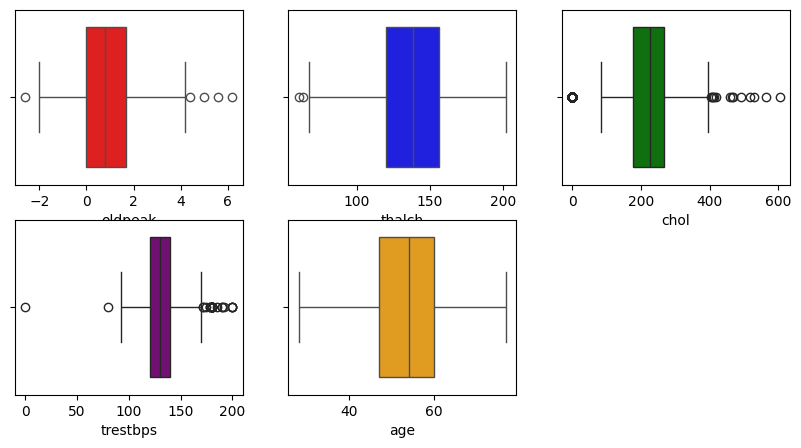

In [18]:
# create boxplots using for loop for all numerical columns
plt.figure(figsize=(10, 5))
colours = ['red','blue','green','purple','orange','black','yellow']
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[col], color=colours[i])
    plt.xlabel(col)


In [19]:
# create boxplots using plotly 
import plotly.graph_objs as go
fig = go.Figure()

for i, col in enumerate(num_cols):
    fig.add_trace(go.Box(y=df[col], name=col))

fig.update_layout(title='Boxplots of Numerical Columns',    
                  xaxis_title='Columns',
                  yaxis_title='Values')

fig.show()


# Columns

In [30]:
df.age.describe()

count    920.000000
mean      53.510870
std        9.424685
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: age, dtype: float64

In [31]:
# printing stats of age column
print(f'The minimum age for heart disease is {df.age.min()}')
print(f'The maximum age for heart disease is {df.age.max()}')
print(f'the average age for heart disease is {df.age.mean()}')
print(f'the median age for heart disease is {df.age.median()}')
print(f'The mod age for heart disease is {df.age.mode()}')

The minimum age for heart disease is 28
The maximum age for heart disease is 77
the average age for heart disease is 53.51086956521739
the median age for heart disease is 54.0
The mod age for heart disease is 0    54
Name: age, dtype: int64


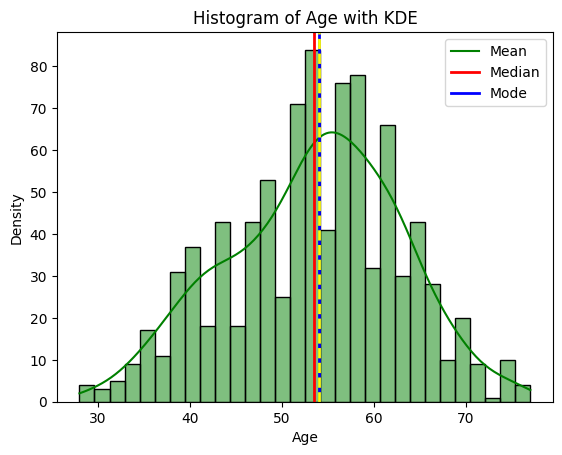

In [32]:
# create histogram for age column with kde
sns.histplot(df.age, kde=True, bins=30, color='green')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Histogram of Age with KDE')

plt.axvline(df.age.mean(), color='red', linestyle='solid', linewidth=2)
plt.axvline(df.age.median(), color='blue', linestyle='solid', linewidth=2)
plt.axvline(df.age.mode()[0], color='yellow', linestyle='dashed', linewidth=2)

plt.legend(['Mean', 'Median', 'Mode'])
plt.show()

# From where data belongs- Dataset Column

In [33]:
df.dataset.unique()

array(['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
      dtype=object)

In [37]:
print(f'The data belongs to follwing sources:\n{df.dataset.value_counts()}')

The data belongs to follwing sources:
dataset
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: count, dtype: int64


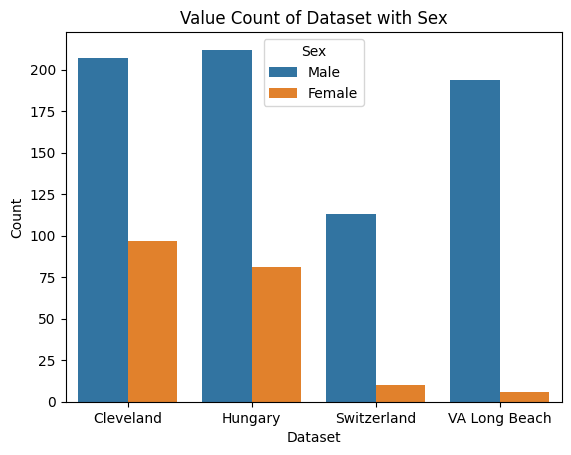

In [38]:
#plot the value count of dataset hue with sex
sns.countplot(x='dataset', hue='sex', data=df)
plt.title('Value Count of Dataset with Sex')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.show()

In [42]:
#plot in ploty for the same
fig = px.histogram(df, x='dataset', color='sex')
fig.update_layout(title='Value Count of Dataset with Sex')
fig.show()

In [46]:
# make a histogram of plotly for age hue with dataset
fig = px.histogram(df, x='age', color='dataset')
fig.update_layout(title='Histogram of Age with dataset')
fig.show()


In [58]:
# print mean, median, mode of age column and groupby dataset
print(f"The mean age for heart disease is {df.groupby('dataset')['age'].agg(['mean','median']).round(2)}")
print(f" the mod of age for heart disease is {df.groupby('dataset')['age'].agg(pd.Series.mode)}")


The mean age for heart disease is                 mean  median
dataset                     
Cleveland      54.35    55.5
Hungary        47.89    49.0
Switzerland    55.32    56.0
VA Long Beach  59.35    60.0
 the mod of age for heart disease is dataset
Cleveland              58
Hungary                54
Switzerland            61
VA Long Beach    [62, 63]
Name: age, dtype: object


In [59]:
df.cp.value_counts()

cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64

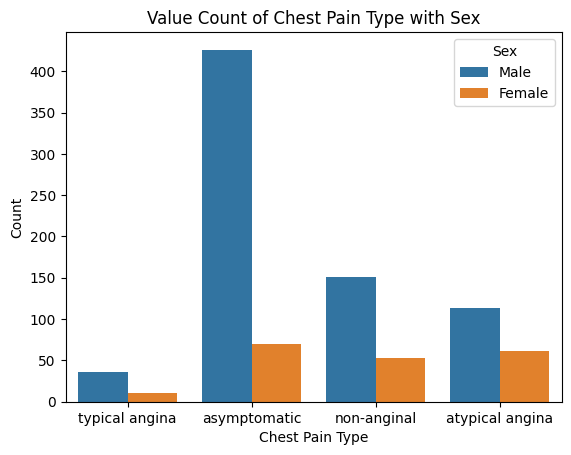

In [60]:
# plot the value count of cp hue with sex
sns.countplot(x='cp', hue='sex', data=df)
plt.title('Value Count of Chest Pain Type with Sex')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.show()

In [61]:
# plot in ploty for the same
fig = px.histogram(df, x='cp', color='sex')
fig.update_layout(title='Value Count of Chest Pain Type with Sex')
fig.show()

In [63]:
#plot the value count of cp hue with age    
#plot the value count of cp hue with age
fig = px.histogram(df, x='age', color='cp', histnorm='percent',
                   labels={'cp':'Chest Pain Type','age':'Age'})
fig.update_layout(title='Value Count of Chest Pain Type with Age')
fig.show()